In [1]:
import json
import numpy as np
import os
import scipy 
from sympy import *
import pylab as plt
import math
import matplotlib.image as mpimg
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
#from pdf2image import convert_from_path
%matplotlib inline

In [2]:
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

BohrInAng = .529177210544
uBohrInAng = .00000000082

HartreeInEV = 27.211386245981
uHartreeInEV = .00000000030

hcInEVAngstrom = 1973.2698044

In [3]:
def Silvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    D = 1.28
    K2eV = 8.617333262e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

def Triplet(x): 
    conv = hcInEVAngstrom / BohrInAng
    R = x * conv
    P = np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    return P * HartreeInEV

def J(Rho):
    R = Rho * hcInEVAngstrom / BohrInAng
    P = np.exp(-.288-.275*R-.176*R**2+.0068*R**3)
    return P * HartreeInEV

def Singlet(R):
    return Silvera_Triplet(R) - J(R)

In [4]:
def pucSilvera_Triplet5(R):
    x = R * hcInEVAngstrom / 4.16 
    return Silvera_Triplet(R)*(1 + .05*x)

def nucSilvera_Triplet5(R):
    x = R * hcInEVAngstrom / 4.16 
    return Silvera_Triplet(R)*(1 + -.05*x)

In [5]:
data = np.genfromtxt('./born-oppenheimer_potentials.csv', delimiter = ',', skip_header=1)
interp_func_sing = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')
interp_func_trip = interp1d(data[:,0], data[:,2], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]
triplet_data = data[:,2]
def Jamieson_Singlet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split=20 
    Decide1=(Rp<split)
    Decide2=(Rp>=split)
    return (Decide1*(interp_func_sing(Rp) + 1) + Decide2*(interp_func_sing(split) + 1)*(Rp/split)**-6) * HartreeInEV

def Jamieson_Triplet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split=20
    Decide1=(Rp<split)
    Decide2=(Rp>=split)
    return (Decide1*(interp_func_trip(Rp) + 1) + Decide2*(interp_func_trip(split) + 1)*(Rp/split)**-6) * HartreeInEV

In [6]:
data =  np.genfromtxt('./triplet.csv', delimiter=',', skip_header=1)
interp_func_trip = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]

def triplet(rho):
    Rp = rho/ BohrInAng * hcInEVAngstrom
    split=10
    Decide1=(Rp<split)
    Decide2=(Rp>=split)
    return (Decide1*(interp_func_trip(Rp) + 1) + Decide2*(interp_func_trip(split) + 1)*(Rp/split)**-6) * HartreeInEV

In [7]:
data = np.genfromtxt('./shortrangesinglet.csv', delimiter=',', skip_header=1)
data2 = np.genfromtxt('./NewerKolos.csv', delimiter=',', skip_header=1)

interp_func = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')
interp_funcnew = interp1d(data2[:,0], -data2[:,1], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]

def singlet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_func(Rp) + 1) * HartreeInEV

new_ranges = np.linspace(.45, 10, 100) / hcInEVAngstrom

def singletnew(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_funcnew(Rp) + 1) * HartreeInEV

def singletcombo(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split1_2=6.3 # Make the split within the range where function has support (between last 2 bins)
    split2_3=11.5 #  [As above]
    Decide1=(Rp<split1_2)
    Decide2=(Rp>=split1_2)*(Rp<split2_3)
    Decide3=(Rp>=split2_3)

    #return (Decide1*(interp_func(R * 1973) + 1)  + Decide2*(interp_funcnew(R * 1973) + 1) + Decide3*(interp_funcnew(10) + 1)*(R*1973.27/10)**-6) * 27.2114

    return (Decide1*(interp_func(Rp) + 1)  + Decide2*(interp_funcnew(Rp) + 1) + Decide3*(interp_funcnew(split2_3) + 1)*(Rp/split2_3)**-6) * HartreeInEV


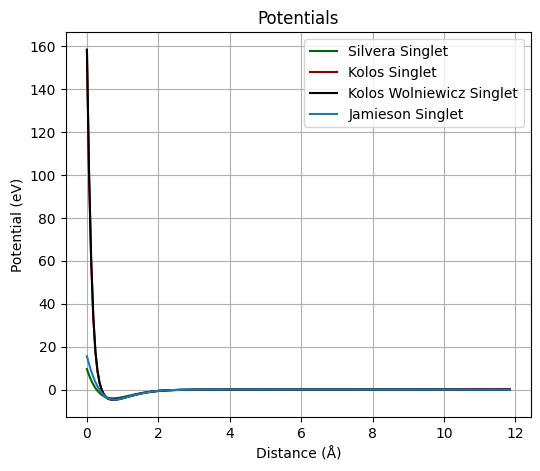

In [8]:
a = .006
rhos = np.linspace(1e-9, a, 200)
plt.figure(figsize=(6, 5))
plt.plot(rhos*hcInEVAngstrom,Singlet(rhos), label="Silvera Singlet", color='DarkGreen')
plt.plot(rhos*hcInEVAngstrom,singlet(rhos), label="Kolos Singlet", color='DarkRed')
plt.plot(rhos*hcInEVAngstrom,singletcombo(rhos), label="Kolos Wolniewicz Singlet", color='black')
plt.plot(rhos*hcInEVAngstrom,Jamieson_Singlet(rhos), label="Jamieson Singlet")
#plt.semilogy()
plt.xlabel("Distance (Å)") 
#plt.xlim(0,8)
plt.ylabel("Potential (eV)") 
#plt.ylim(-6,10)
plt.title("Potentials")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def p_of_temp(mu, T):
    J2eV = 6.241508074e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

In [10]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]

def Wave_FunctionDip(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 20000)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0] ,rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2) 
    return State.y[0]/Normalization[-1]


def Wave_FunctionEx(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return (np.sqrt(2/np.pi)*State.y[0]/Normalization[-1],np.sqrt(2/np.pi)*State.y[1]/Normalization[-1])

In [11]:
def GetIntegral (alphain, betain, alphaout, betaout, mass, A, r0, temp, version, how_to_int):
    rhos = np.linspace(r0, A, 20000)

    P1 = p_of_temp(mass, temp)
    P2 = pprime(P1, alphain, betain, alphaout, betaout, mass)
    
    InState = np.array(Wave_FunctionDip(P1, 0, A, r0, ddx, mass, version, how_to_int))
    OutState = np.array(Wave_FunctionDip(P2, 2, A, r0, ddx, mass, version, how_to_int))

    Integrand = interp1d(rhos, InState * OutState / rhos**3, kind = 'quadratic')
    
    Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)

    return Integral

def GetSpatialsDip (mu, B, couple, levels, version):
    aaSpatials = []
    acSpatials = []
    adSpatials = []
    ccSpatials = []
    cdSpatials = []

    Conversion = 11.6
    Pre_Factor  = 1/(5*np.pi) * couple**4
    
    i = 0
    for b in B:
        a = levels['a'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-4
        intlimit = .75

        Pin = p_of_temp(mu, temp)
        Paa_out = pprime(Pin, d, d, a, a, mu)
        Pac_out = pprime(Pin, d, d, a, c, mu)
        Pad_out = pprime(Pin, d, d, a, d, mu)
        Pcc_out = pprime(Pin, d, d, c, c, mu)
        Pcd_out = pprime(Pin, d, d, c, d, mu)

        if b<= 8.5:
            aaIntegral = GetIntegral(d, d, a, a, mu, intlimit, r0, temp, version, 'Radau')
        else:
            aaIntegral = GetIntegral(d, d, a, a, mu, intlimit, r0, temp, version, 'RK45')

        acIntegral = GetIntegral(d, d, a, c, mu, intlimit, r0, temp, version, 'Radau')
        adIntegral = GetIntegral(d, d, a, d, mu, intlimit, r0, temp, version, 'Radau')
        ccIntegral = GetIntegral(d, d, c, c, mu, intlimit, r0, temp, version, 'Radau')
        cdIntegral = GetIntegral(d, d, c, d, mu, intlimit, r0, temp, version, 'Radau')

        aaSpatials.append(Conversion * Pre_Factor * Paa_out * mu * aaIntegral**2)
        acSpatials.append(Conversion * Pre_Factor * Pac_out * mu * acIntegral**2)
        adSpatials.append(Conversion * Pre_Factor * Pad_out * mu * adIntegral**2)
        ccSpatials.append(Conversion * Pre_Factor * Pcc_out * mu * ccIntegral**2)
        cdSpatials.append(Conversion * Pre_Factor * Pcd_out * mu * cdIntegral**2)

        i = i + 1

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    adSpatials = np.array(adSpatials)
    ccSpatials = np.array(ccSpatials)
    cdSpatials = np.array(cdSpatials)

    return (aaSpatials, acSpatials, adSpatials, ccSpatials, cdSpatials)

In [12]:
def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    
    State = np.array(Wave_FunctionEx(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_FunctionEx(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    Big = Big_delta_l = (rhos * Statedev - State) / (rhos * State)
    jl_ka = spherical_jn(l, p * rhos)
    jl_prime_ka = spherical_jn(l, p * rhos, derivative=True)
    nl_ka = spherical_yn(l, p * rhos)
    nl_prime_ka = spherical_yn(l, p * rhos, derivative=True)

    #deltas = np.arctan((p*jl_prime_ka - Big_delta_l*jl_ka) / (p*nl_prime_ka - Big_delta_l * nl_ka)) 
    deltas=np.arctan(p*State/Statedev)-p*rhos
    return deltas[-1]

def GetSpatialsEx(mu, B, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    i = 0
    for bs in B:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-6
        intlimit = 10 * BohrInAng/hcInEVAngstrom #When running with Kolos potential use 10 * when using Silvera potential use 20*

        Pin = p_of_temp(mu, temp)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const = np.pi / (mu * Pin)
        
        tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(11.6 * const * (Pin * Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(11.6 * const * (Pin * Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(11.6 * const * (Pin * Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

        i = i + 1

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [13]:
B_Values = np.logspace(-3,1,50)

In [14]:
def GetHyperFineLevels(pm, mf, delW, mN, gI, ge, meeV, mue):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.241509074e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI, ge, meeV, mue): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI, ge, meeV, mue))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [15]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
udelWH = .0000000000010e9
delWT = 1.516701470775e9
udelWT = .0000000000007e9

gIH = 5.585694706 # Hydrogen nuclear g-factor
ugIH = .000000056
gIT = 5.957924930 
ugIT = .000000012
mH = 1.00727646657894 #Mass of hydrogen in Dalton
umH = .0000000000083
mT = 3.01550071597 
umT = .00000000010

ge = 2.00231930436092
uge = .00000000000036
meeV = .51099895069e6
umeeV = .00000000016e6
mue = 9.2847646917e-24
umue = .0000000029e-24

HLevels = AllHFLevels(delWH, mH, gIH, ge, meeV, mue)
TLevels = AllHFLevels(delWT, mT, gIT, ge, meeV, mue)

In [16]:
meeV = .51099895069e6
Hm = 938.27208942e6 + meeV #Mass of hydrogen in eV/c^2
uHm =.00000029e6
uHm = np.sqrt(uHm**2 + umeeV**2)
Tm = 2808.92113668e6 + meeV
uTm = .00000028e6
Hmu = Hm/2
uHmu = uHm/2
Tmu = Tm/2
uTmu = uTm/2

gamH=42.56385437*1e6 # In Hz T^-1
ugamH = .000000018*1e6
gamT=45.41483817*1e6 # In Hz T^-1
ugamT = .000000021*1e6

alpha = 7.2973525643e-3
ualpha = .0000000011e-3
mu_dip_couple = np.sqrt(4 * np.pi * alpha) / (2 * meeV)
umu_dip_couple = mu_dip_couple * (ualpha/alpha + umeeV/meeV)

In [17]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [18]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [19]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [20]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [21]:
SingletProj=np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

TripletProj=np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0,  0.5,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ])

In [22]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]

    # aa      bb    cc  dd     ab ab  ac     ac  ad  ad  bc  bc  bd  bd  cd  cd 
Rotator=np.array([
    [c*c,     0,    s*s,0,     0,  0,sr2*s*c, 0,  0,  0,  0,  0,  0,  0,  0,  0],   #aa
    [0,       1,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #bb
    [s*s,     0,    c*c,0,     0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],   #cc
    [0,       0,    0,  1,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #dd
    [0,       0,    0,  0,     c,  0,  0,     0,  0,  0,  s,  0,  0,  0,  0,  0],   #ab
    [0,       0,    0,  0,     0,  c,  0,     0,  0,  0,  0,  s,  0,  0,  0,  0],   #ab
    [-sr2*s*c,0,sr2*s*c,0,     0,  0, c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],   #ac  
    [0,       0,    0,  0,     0,  0,  0,     1,  0,  0,  0,  0,  0,  0,  0,  0],   #ac
    [0,       0,    0,  0,     0,  0,  0,     0,  c,  0,  0,  0,  0,  0,  s,  0],   #ad
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  c,  0,  0,  0,  0,  0,  s],   #ad
    [0,       0,    0,  0,    -s,  0,  0,     0,  0,  0,  c,  0,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  -s, 0,     0,  0,  0,  0,  c,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  1,  0,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  1,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  -s, 0,  0,  0,  0,  0,  c,  0],   #cd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  -s, 0,  0,  0,  0,  0,  c]    #cd
                        ])

In [23]:
Sig2m2proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])


Sig2p2proj=-1/2*np.array([
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])
#sr2=np.sqrt(2)
Sig2p1proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0, -1/sr2,0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

Sig2m1proj=1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,1/sr2, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [-1/(2*sr2), 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,-1/(2*sr2),  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0]
                ])

Sig20proj=-np.sqrt(3/2)*np.array([
    [1/6,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/6, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/6]
                ])

Sigmas={-2:Sig2m2proj,-1:Sig2m1proj,0:Sig20proj,1:Sig2p1proj,2:Sig2p2proj}

In [24]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))

def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [25]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [26]:
Rets={}
for m in Sigmas.keys():
    SigMatrix=Sigmas[m]
    Rets[m]=TransformMatrix(np.matmul(np.matmul(TripletProj,SigMatrix),TripletProj),Rotator)

In [27]:
def Theta(a, B, magN):
    muplus=mage + magN  # In notation of Silvera and Walraven
    return (0.5*np.arctan(a / (B * muplus))) #has large B limit -> a/ (2 muplus B) as reqd

def ThetaDip(a,B,gamN):
    game=-28024.9*1e6 # In Hz T^-1
    return(0.5*np.arctan(a/(2*B*(game+gamN))))

In [28]:
Hm = 938.78e6 #Mass of hydrogen in eV/c^2
Tm = 2808.9261e6
Hmu = Hm/2
Tmu = Tm/2

delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
#gyromagnetic constants 
gamH=42.577*1e6 # In Hz T^-1
gamT=45.415*1e6 # In Hz T^-1

def GetSpinsDip(delW, B, gam):
    NormDiff = 4*np.sqrt(6)
    letters = ['a', 'c', 'd']
    a1 = 'd'
    a2 = 'd' 

    aaSpins = []
    acSpins = []
    adSpins = []
    ccSpins = []
    cdSpins = []

    for a3 in letters:
        for a4 in letters:
            line = []
            for b in B:
                theta = ThetaDip(delW, b, gam)
                value = 0 
                for m in Rets.keys():
                    El = ( GetElement(Rets[m], a1, a2, 1, a3, a4, 1)) **2
                    try: 
                        value += El.subs(sr2, np.sqrt(2)) \
                                .subs(sr3, np.sqrt(3)) \
                                .subs(c, np.cos(theta)) \
                                .subs(s, np.sin(theta))
                    except:
                        value += 0
                line.append(value)
            if a3 == 'a' and a4 == 'a':
                aaSpins = line  
            elif a3 == 'a' and a4 == 'c':
                acSpins = line
            elif a3 == 'a'  and a4 == 'd':
                adSpins = line
            elif a3 == 'c' and a4 == 'c':
                ccSpins = line
            elif a3 == 'c' and a4 == 'd':
                cdSpins = line

    aaSpins = np.array(aaSpins)*NormDiff**2
    acSpins = np.array(acSpins)*NormDiff**2
    adSpins = np.array(adSpins)*NormDiff**2
    ccSpins = np.array(ccSpins)*NormDiff**2
    cdSpins = np.array(cdSpins)*NormDiff**2

    return(aaSpins, acSpins, adSpins, ccSpins, cdSpins)    

In [29]:
def GetspinEx(a, B_values, magN, a3, a4):
    line = []
    for Bs in B_values:
        th = Theta(a, Bs,magN )
        
        SpinPart = TransformMatrix(TripletProj-SingletProj,Rotator)

        El=(GetElement(SpinPart,"c","c",1,a3,a4,1))**2
        Value=El.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))

        line.append(Value)
    line = np.array(line)
    return line

In [30]:
meeV = .51099895069e6
Hm = 938.27208942e6 + meeV #Mass of hydrogen in eV/c^2
Tm = 2808.92113668e6 + meeV
Hmu = Hm/2
Tmu = Tm/2

gamH=42.56385437*1e6 # In Hz T^-1
gamT=45.41483817*1e6 # In Hz T^-1

muN = 5.0507837393e-27
mue = 9.2847646917e-24
ge = 2.0023193043609

magH = gIH * muN  
magT = gIT * muN   
mage = ge * mue  

hbar =6.62607015e-34
aH= delWH * hbar

In [31]:
muN = 5.0507837393e-27
umuN = .0000000016e-27
mue = 9.2847646917e-24
umue = .0000000029e-24


magH = gIH * muN  
umagH = np.sqrt(ugIH**2 + umuN**2)
magT = gIT * muN   
umagT = np.sqrt(ugIT**2 + umuN**2)
mage = ge * mue  
umage = np.sqrt(uge**2 + umue**2)

hbar =6.62607015e-34
aH= delWH * hbar
aT= delWT * hbar

HExSpatials = GetSpatialsEx(Hmu, B_Values, HLevels, Silvera_Triplet, singletcombo)
TExSpatials = GetSpatialsEx(Tmu, B_Values, TLevels, Silvera_Triplet, singletcombo)

HExSpins = [
    GetspinEx(aH, B_Values, magH, 'a', 'a'),
    GetspinEx(aH, B_Values, magH, 'a', 'c'),
    GetspinEx(aH, B_Values, magH, 'b', 'd')
]
TExSpins = [
    GetspinEx(aT, B_Values, magT, 'a', 'a'),
    GetspinEx(aT, B_Values, magT, 'a', 'c'),
    GetspinEx(aT, B_Values, magT, 'b', 'd')
]

In [32]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
#gyromagnetic constants 
gamH=42.577*1e6 # In Hz T^-1
gamT=45.415*1e6 # In Hz T^-1

HDipSpatials = GetSpatialsDip(Hmu, B_Values, mu_dip_couple, HLevels, Silvera_Triplet)
TDipSpatials = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, Silvera_Triplet)

HDipSpins = GetSpinsDip(delWH, B_Values, gamH)
TDipSpins = GetSpinsDip(delWT, B_Values, gamT)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWar

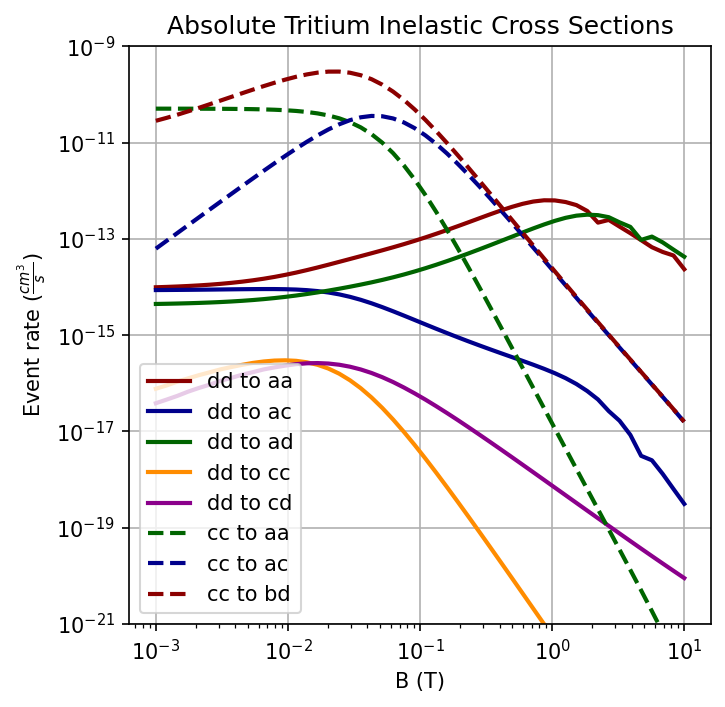

In [33]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0],label="dd to aa", color = "DarkRed", linewidth=2)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1],label="dd to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2],label="dd to ad", color = "DarkGreen",linewidth=2)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3],label="dd to cc", color = "DarkOrange", linewidth=2)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4],label="dd to cd", color = "DarkMagenta", linewidth=2)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0],  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1],  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2],  '--', label="cc to bd", color = "DarkRed", linewidth=2)

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-9)
plt.title("Absolute Tritium Inelastic Cross Sections")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [34]:
lets = ['a', 'b', 'c', 'd']
ucTLevels = {let: [] for let in lets}
for let in lets:
    i = 0
    for bs in B_Values:
        cudelWT = 1/2 * (AllHFLevels(delWT + udelWT/np.sqrt(12), mT, gIT, ge, meeV, mue)[let][i] - AllHFLevels(delWT - udelWT/np.sqrt(12), mT, gIT, ge, meeV, mue)[let][i])
        cumT = 1/2 * (AllHFLevels(delWT, mT + umT/np.sqrt(12), gIT, ge, meeV, mue)[let][i] - AllHFLevels(delWT, mT - umT/np.sqrt(12), gIT, ge, meeV, mue)[let][i])
        cugIT = 1/2 * (AllHFLevels(delWT, mT, gIT + ugIT/np.sqrt(12), ge, meeV, mue)[let][i] - AllHFLevels(delWT, mT, gIT - ugIT/np.sqrt(12), ge, meeV, mue)[let][i])
        cuge = 1/2 * (AllHFLevels(delWT, mT, gIT, ge + uge/np.sqrt(12), meeV, mue)[let][i] - AllHFLevels(delWT, mT, gIT, ge - uge/np.sqrt(12), meeV, mue)[let][i])
        cumeeV = 1/2 * (AllHFLevels(delWT, mT, gIT, ge, meeV + umeeV/np.sqrt(12), mue)[let][i] - AllHFLevels(delWT, mT, gIT, ge, meeV - umeeV/np.sqrt(12), mue)[let][i])
        cumue = 1/2 * (AllHFLevels(delWT, mT, gIT, ge, meeV, mue + umue/np.sqrt(12))[let][i] - AllHFLevels(delWT, mT, gIT, ge, meeV, mue - umue/np.sqrt(12))[let][i])

        uc = np.sqrt(cudelWT**2 + cumT**2 + cugIT**2 + cuge**2 + cumeeV**2  + cumue**2)
        ucTLevels[let].append(uc)
        i = i + 1

In [35]:
lets = ['a', 'c', 'd']
ucTExSpin = {let: [] for let in lets}
for let in lets: 
    if let == 'a':
        a1 = 'a'
        a2 = 'a'
    elif let == 'c':
        a1 = 'a'
        a2 = 'c'
    else:
        a1 = 'b'
        a2 = 'd'
    ca = np.asarray(1/2 * (GetspinEx(aT + udelWT/np.sqrt(12), B_Values, magT, a1, a2) - GetspinEx(aT - udelWT/np.sqrt(12), B_Values, magT, a1, a2)),dtype=float)
    cmag = np.asarray(1/2 * (GetspinEx(aT, B_Values, magT + umagT/np.sqrt(12), a1, a2) - GetspinEx(aT, B_Values, magT - umagT/np.sqrt(12), a1, a2)),dtype=float)
    ucTExSpin[let] = np.sqrt(ca**2 + cmag**2)

In [36]:
upper_WT = np.array(GetSpinsDip(delWT + udelWT / np.sqrt(12), B_Values, gamT), dtype=float)
lower_WT = np.array(GetSpinsDip(delWT - udelWT / np.sqrt(12), B_Values, gamT), dtype=float)
cWT = 0.5 * (upper_WT - lower_WT)

upper_gamT = np.array(GetSpinsDip(delWT, B_Values, gamT + ugamT / np.sqrt(12)), dtype=float)
lower_gamT = np.array(GetSpinsDip(delWT, B_Values, gamT - ugamT / np.sqrt(12)), dtype=float)
cgamT = 0.5 * (upper_gamT - lower_gamT)

ucTDipSpin = np.sqrt(cWT**2 + cgamT**2)

In [37]:
for k in ['a','b','c','d']:                       
    ucTLevels[k] = np.asarray(ucTLevels[k], dtype=float) / np.sqrt(12)
    
def bump_TLevels(sign=+1):
    return {k: np.asarray(TLevels[k], dtype=float) + sign*ucTLevels[k]for k in TLevels}

In [38]:
ucTSpatialsEx = [0,1,2]
for i in [0,1,2]:
    cTmu = 1/2 * (GetSpatialsEx(Tmu+uTmu / np.sqrt(12),B_Values, TLevels, Silvera_Triplet, singletcombo)[i] - GetSpatialsEx(Tmu-uTmu / np.sqrt(12),B_Values, TLevels, Silvera_Triplet, singletcombo)[i])
    cTLevels = 1/2 * (GetSpatialsEx(Tmu,B_Values, bump_TLevels(+1), Silvera_Triplet, singletcombo)[i] - GetSpatialsEx(Tmu,B_Values, bump_TLevels(-1), Silvera_Triplet, singletcombo)[i])
    ucTSpatialsEx[i] = np.sqrt(cTmu**2 + cTLevels**2)

In [39]:
ucTSpatialsDip = [0,1,2,3,4]
for i in [0,1,2,3,4]:
    upper_mu = np.array(GetSpatialsDip(Tmu + uTmu / np.sqrt(12), B_Values, mu_dip_couple, TLevels, Silvera_Triplet)[i], dtype = float)
    lower_mu = np.array(GetSpatialsDip(Tmu - uTmu / np.sqrt(12), B_Values, mu_dip_couple, TLevels, Silvera_Triplet)[i], dtype = float)
    cmu = .5 * (upper_mu - lower_mu)
    
    upper_couple = np.array(GetSpatialsDip(Tmu , B_Values, mu_dip_couple + umu_dip_couple / np.sqrt(12), TLevels, Silvera_Triplet)[i], dtype = float)
    lower_couple = np.array(GetSpatialsDip(Tmu , B_Values, mu_dip_couple - umu_dip_couple / np.sqrt(12), TLevels, Silvera_Triplet)[i], dtype = float)
    ccouple = .5 * (upper_couple - lower_couple)

    cTLevels = .5 * (GetSpatialsDip(Tmu,B_Values, mu_dip_couple, bump_TLevels(+1), Silvera_Triplet)[i] - GetSpatialsDip(Tmu,B_Values, mu_dip_couple, bump_TLevels(-1), Silvera_Triplet)[i])

    ucTSpatialsDip[i] = np.sqrt(cmu**2 + ccouple**2 + cTLevels**2)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


In [40]:
upTSpatialsEx = GetSpatialsEx(Tmu, B_Values,TLevels, pucSilvera_Triplet5, singletcombo)
downTSpatialsEx = GetSpatialsEx(Tmu, B_Values,TLevels, nucSilvera_Triplet5, singletcombo)

In [41]:
upTDipSpatials = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, pucSilvera_Triplet5)
downTDipSpatials = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, nucSilvera_Triplet5)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tole

In [42]:
uSpatialEx = [
    np.asarray(ucTSpatialsEx[0], dtype=float),
    np.asarray(ucTSpatialsEx[1], dtype=float),
    np.asarray(ucTSpatialsEx[2], dtype=float)
]

SpatialEx = [
    np.asarray(TExSpatials[0], dtype=float),
    np.asarray(TExSpatials[1], dtype=float),
    np.asarray(TExSpatials[2], dtype=float)
]

uSpinEx = [
    np.asarray(ucTExSpin['a'], dtype=float),
    np.asarray(ucTExSpin['c'], dtype=float),
    np.asarray(ucTExSpin['d'], dtype=float)
]

SpinEx = [
    np.asarray(TExSpins[0], dtype=float),
    np.asarray(TExSpins[1], dtype=float),
    np.asarray(TExSpins[2], dtype=float)
]

frac_uncEx = [
    np.sqrt((uSpatialEx[0] / SpatialEx[0])**2 + (uSpinEx[0] / SpinEx[0])**2),
    np.sqrt((uSpatialEx[1] / SpatialEx[1])**2 + (uSpinEx[1] / SpinEx[1])**2),
    np.sqrt((uSpatialEx[2] / SpatialEx[2])**2 + (uSpinEx[2] / SpinEx[2])**2)
]

uncertEx = [
    frac_uncEx[0] * SpatialEx[0] * SpinEx[0],
    frac_uncEx[1] * SpatialEx[1] * SpinEx[1],
    frac_uncEx[2] * SpatialEx[2] * SpinEx[2]
]

In [43]:
uSpatialDip = [
    np.asarray(ucTSpatialsDip[0], dtype=float),
    np.asarray(ucTSpatialsDip[1], dtype=float),
    np.asarray(ucTSpatialsDip[2], dtype=float),
    np.asarray(ucTSpatialsDip[3], dtype=float),
    np.asarray(ucTSpatialsDip[4], dtype=float)
]

SpatialDip = [
    np.asarray(TDipSpatials[0], dtype=float),
    np.asarray(TDipSpatials[1], dtype=float),
    np.asarray(TDipSpatials[2], dtype=float),
    np.asarray(TDipSpatials[3], dtype=float),
    np.asarray(TDipSpatials[4], dtype=float)
]

uSpinDip = [
    np.asarray(ucTDipSpin[0], dtype=float),
    np.asarray(ucTDipSpin[1], dtype=float),
    np.asarray(ucTDipSpin[2], dtype=float),
    np.asarray(ucTDipSpin[3], dtype=float),
    np.asarray(ucTDipSpin[4], dtype=float)
]

SpinDip = [
    np.asarray(TDipSpins[0], dtype=float),
    np.asarray(TDipSpins[1], dtype=float),
    np.asarray(TDipSpins[2], dtype=float),
    np.asarray(TDipSpins[3], dtype=float),
    np.asarray(TDipSpins[4], dtype=float)
]

frac_uncDip = [
    np.sqrt((uSpatialDip[0] / SpatialDip[0])**2 + (uSpinDip[0] / SpinDip[0])**2),
    np.sqrt((uSpatialDip[1] / SpatialDip[1])**2 + (uSpinDip[1] / SpinDip[1])**2),
    np.sqrt((uSpatialDip[2] / SpatialDip[2])**2 + (uSpinDip[2] / SpinDip[2])**2),
    np.sqrt((uSpatialDip[3] / SpatialDip[3])**2 + (uSpinDip[3] / SpinDip[3])**2),
    np.sqrt((uSpatialDip[4] / SpatialDip[4])**2 + (uSpinDip[4] / SpinDip[4])**2)
]

uncertDip = [
    frac_uncDip[0] * SpatialDip[0] * SpinDip[0],
    frac_uncDip[1] * SpatialDip[1] * SpinDip[1],
    frac_uncDip[2] * SpatialDip[2] * SpinDip[2],
    frac_uncDip[3] * SpatialDip[3] * SpinDip[3],
    frac_uncDip[4] * SpatialDip[4] * SpinDip[4]
]

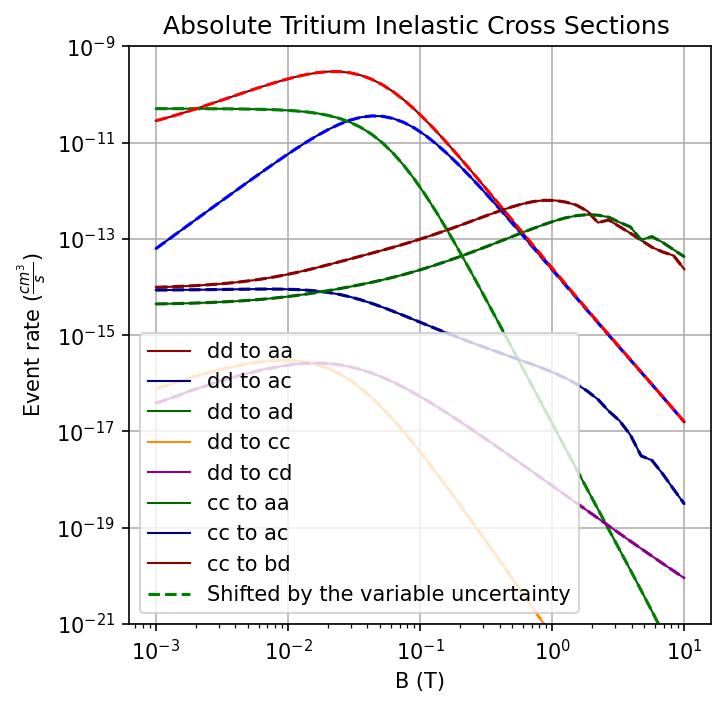

In [72]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0],label="dd to aa", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1],label="dd to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2],label="dd to ad", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3],label="dd to cc", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4],label="dd to cd", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0], label="cc to aa", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1], label="cc to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2], label="cc to bd", color = "DarkRed", linewidth=1)

plt.plot(B_Values,np.asarray(TExSpatials[0] * TExSpins[0], dtype=float) + uncertEx[0],label="Shifted by the variable uncertainty",color="Green",linestyle='--')
plt.plot(B_Values,np.asarray(TExSpatials[1]*TExSpins[1],dtype=float) + uncertEx[1],  '--', color = "Blue")
plt.plot(B_Values,np.asarray(TExSpatials[2]*TExSpins[2],dtype=float) + uncertEx[2],  '--', color = "Red")
plt.plot(B_Values,np.asarray(TDipSpatials[0]*TDipSpins[0],dtype=float) + uncertDip[0],  '--', color = "DarkRed")
plt.plot(B_Values,np.asarray(TDipSpatials[1]*TDipSpins[1],dtype=float) + uncertDip[1],  '--', color = "DarkBlue")
plt.plot(B_Values,np.asarray(TDipSpatials[2]*TDipSpins[2],dtype=float) + uncertDip[2],  '--', color = "DarkGreen")
plt.plot(B_Values,np.asarray(TDipSpatials[3]*TDipSpins[3],dtype=float) + uncertDip[3],  '--', color = "DarkOrange")
plt.plot(B_Values,np.asarray(TDipSpatials[4]*TDipSpins[4],dtype=float) + uncertDip[4],  '--', color = "DarkMagenta")

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-9)
plt.title("Absolute Tritium Inelastic Cross Sections ")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

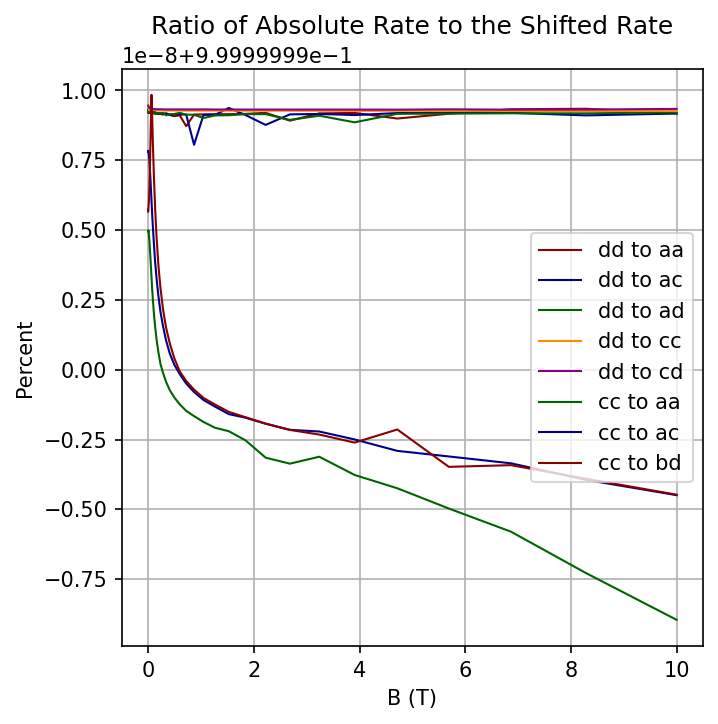

In [73]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0] / (np.asarray(TDipSpatials[0]*TDipSpins[0],dtype=float) + uncertDip[0]),label="dd to aa", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1] / (np.asarray(TDipSpatials[1]*TDipSpins[1],dtype=float) + uncertDip[1]),label="dd to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2] / (np.asarray(TDipSpatials[2]*TDipSpins[2],dtype=float) + uncertDip[2]),label="dd to ad", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3] / (np.asarray(TDipSpatials[3]*TDipSpins[3],dtype=float) + uncertDip[3]),label="dd to cc", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4] / (np.asarray(TDipSpatials[4]*TDipSpins[4],dtype=float) + uncertDip[4]),label="dd to cd", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0] / (np.asarray(TExSpatials[0]*TExSpins[0],dtype=float) + uncertEx[0]), label="cc to aa", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1] / (np.asarray(TExSpatials[1]*TExSpins[1],dtype=float) + uncertEx[1]), label="cc to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2] / (np.asarray(TExSpatials[2]*TExSpins[2],dtype=float) + uncertEx[2]), label="cc to bd", color = "DarkRed", linewidth=1)
plt.xlabel("B (T)")
plt.ylabel("Percent")
plt.title("Ratio of Absolute Rate to the Shifted Rate")
plt.grid(True)
plt.legend()
plt.show()

In [46]:
HDipSpatialsOld = GetSpatialsDip(Hmu, B_Values, mu_dip_couple, HLevels, Triplet)
TDipSpatialsOld = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, Triplet)

HExSpatialsOld = GetSpatialsEx(Hmu, B_Values, HLevels, Triplet, singletcombo)
TExSpatialsOld = GetSpatialsEx(Tmu, B_Values, TLevels, Triplet, singletcombo)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


In [47]:
HDipSpatialsKolos = GetSpatialsDip(Hmu, B_Values, mu_dip_couple, HLevels, triplet)
TDipSpatialsKolos = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, triplet)

HExSpatialsKolos = GetSpatialsEx(Hmu, B_Values, HLevels, triplet, singletcombo)
TExSpatialsKolos = GetSpatialsEx(Tmu, B_Values, TLevels, triplet, singletcombo)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


In [48]:
HDipSpatialsJam = GetSpatialsDip(Hmu, B_Values, mu_dip_couple, HLevels, Jamieson_Triplet)
TDipSpatialsJam = GetSpatialsDip(Tmu, B_Values, mu_dip_couple, TLevels, Jamieson_Triplet)

HExSpatialsJam = GetSpatialsEx(Hmu, B_Values, HLevels, Jamieson_Triplet, singletcombo)
TExSpatialsJam = GetSpatialsEx(Tmu, B_Values, TLevels, Jamieson_Triplet, singletcombo)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


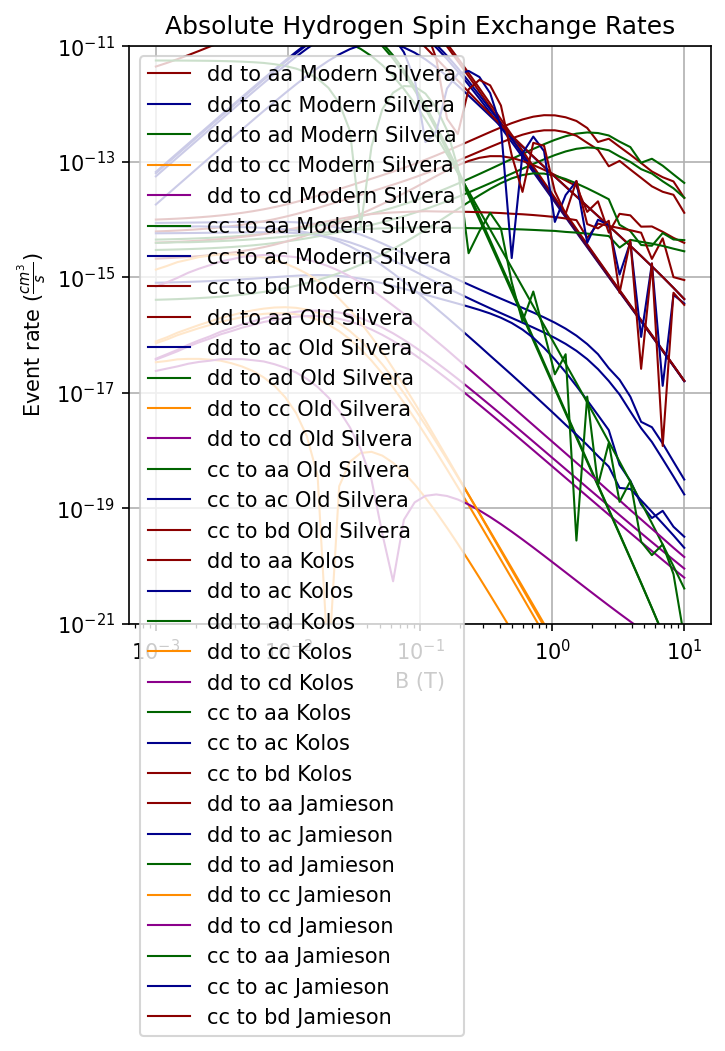

In [49]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0],label="dd to aa Modern Silvera", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1],label="dd to ac Modern Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2],label="dd to ad Modern Silvera", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3],label="dd to cc Modern Silvera", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4],label="dd to cd Modern Silvera", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0], label="cc to aa Modern Silvera", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1], label="cc to ac Modern Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2], label="cc to bd Modern Silvera", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpins[0] * TDipSpatialsOld[0],label="dd to aa Old Silvera", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatialsOld[1],label="dd to ac Old Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatialsOld[2],label="dd to ad Old Silvera", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatialsOld[3],label="dd to cc Old Silvera", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatialsOld[4],label="dd to cd Old Silvera", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatialsOld[0], label="cc to aa Old Silvera", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatialsOld[1], label="cc to ac Old Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatialsOld[2], label="cc to bd Old Silvera", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpins[0] * TDipSpatialsKolos[0],label="dd to aa Kolos", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatialsKolos[1],label="dd to ac Kolos", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatialsKolos[2],label="dd to ad Kolos", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatialsKolos[3],label="dd to cc Kolos", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatialsKolos[4],label="dd to cd Kolos", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatialsKolos[0], label="cc to aa Kolos", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatialsKolos[1], label="cc to ac Kolos", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatialsKolos[2], label="cc to bd Kolos", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpins[0] * TDipSpatialsJam[0],label="dd to aa Jamieson", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatialsJam[1],label="dd to ac Jamieson", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatialsJam[2],label="dd to ad Jamieson", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatialsJam[3],label="dd to cc Jamieson", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatialsJam[4],label="dd to cd Jamieson", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatialsJam[0], label="cc to aa Jamieson", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatialsJam[1], label="cc to ac Jamieson", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatialsJam[2], label="cc to bd Jamieson", color = "DarkRed", linewidth=1)

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-11)
plt.title("Absolute Hydrogen Spin Exchange Rates")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

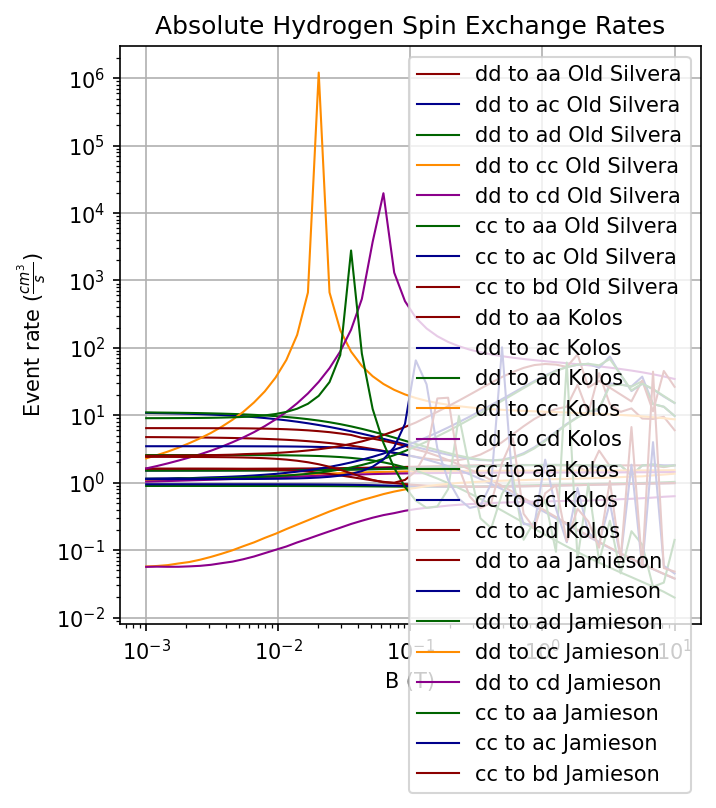

In [50]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpatials[0] / TDipSpatialsOld[0],label="dd to aa Old Silvera", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpatials[1] / TDipSpatialsOld[1],label="dd to ac Old Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpatials[2] / TDipSpatialsOld[2],label="dd to ad Old Silvera", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpatials[3] / TDipSpatialsOld[3],label="dd to cc Old Silvera", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpatials[4] / TDipSpatialsOld[4],label="dd to cd Old Silvera", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpatials[0] / TExSpatialsOld[0], label="cc to aa Old Silvera", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpatials[1] / TExSpatialsOld[1], label="cc to ac Old Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpatials[2] / TExSpatialsOld[2], label="cc to bd Old Silvera", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpatials[0] / TDipSpatialsKolos[0],label="dd to aa Kolos", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpatials[1] / TDipSpatialsKolos[1],label="dd to ac Kolos", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpatials[2] / TDipSpatialsKolos[2],label="dd to ad Kolos", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpatials[3] / TDipSpatialsKolos[3],label="dd to cc Kolos", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpatials[4] / TDipSpatialsKolos[4],label="dd to cd Kolos", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpatials[0] / TExSpatialsKolos[0], label="cc to aa Kolos", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpatials[1] / TExSpatialsKolos[1], label="cc to ac Kolos", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpatials[2] / TExSpatialsKolos[2], label="cc to bd Kolos", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpatials[0] / TDipSpatialsJam[0],label="dd to aa Jamieson", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpatials[1] / TDipSpatialsJam[1],label="dd to ac Jamieson", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpatials[2] / TDipSpatialsJam[2],label="dd to ad Jamieson", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpatials[3] / TDipSpatialsJam[3],label="dd to cc Jamieson", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpatials[4] / TDipSpatialsJam[4],label="dd to cd Jamieson", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpatials[0] / TExSpatialsJam[0], label="cc to aa Jamieson", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpatials[1] / TExSpatialsJam[1], label="cc to ac Jamieson", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpatials[2] / TExSpatialsJam[2], label="cc to bd Jamieson", color = "DarkRed", linewidth=1)

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Absolute Hydrogen Spin Exchange Rates")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [51]:
HDipSpatialsAtomic = GetSpatialsDip(Hmu - meeV/2, B_Values, mu_dip_couple, HLevels, Silvera_Triplet)
TDipSpatialsAtomic = GetSpatialsDip(Tmu - meeV/2, B_Values, mu_dip_couple, TLevels, Silvera_Triplet)

HExSpatialsAtomic = GetSpatialsEx(Hmu - meeV/2, B_Values, HLevels, Silvera_Triplet, singletcombo)
TExSpatialsAtomic = GetSpatialsEx(Tmu - meeV/2, B_Values, TLevels, Silvera_Triplet, singletcombo)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWar

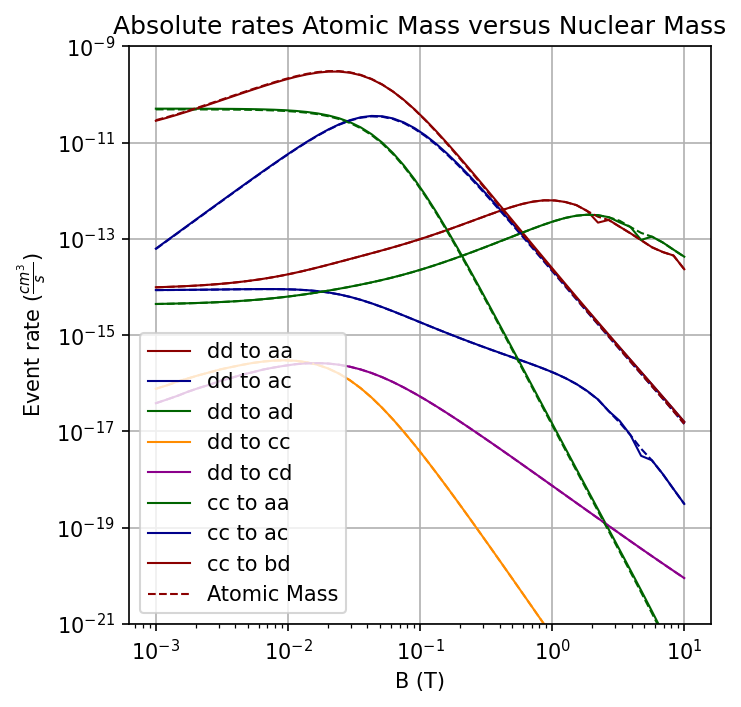

In [76]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0],label="dd to aa", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1],label="dd to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2],label="dd to ad", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3],label="dd to cc", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4],label="dd to cd", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0], label="cc to aa", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1], label="cc to ac", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2], label="cc to bd", color = "DarkRed", linewidth=1)

plt.plot(B_Values,TDipSpins[0] * TDipSpatialsAtomic[0],label="Atomic Mass", color = "DarkRed", linewidth=1, linestyle='--')
plt.plot(B_Values,TDipSpins[1] * TDipSpatialsAtomic[1], color = "DarkBlue", linewidth=1, linestyle='--')
plt.plot(B_Values,TDipSpins[2] * TDipSpatialsAtomic[2], color = "DarkGreen",linewidth=1, linestyle='--')
plt.plot(B_Values,TDipSpins[3] * TDipSpatialsAtomic[3], color = "DarkOrange", linewidth=1, linestyle='--')
plt.plot(B_Values,TDipSpins[4] * TDipSpatialsAtomic[4], color = "DarkMagenta", linewidth=1, linestyle='--')
plt.plot(B_Values,TExSpins[0] * TExSpatialsAtomic[0], color = "DarkGreen", linewidth=1, linestyle='--')
plt.plot(B_Values,TExSpins[1] * TExSpatialsAtomic[1], color = "DarkBlue", linewidth=1, linestyle='--')
plt.plot(B_Values,TExSpins[2] * TExSpatialsAtomic[2], color = "DarkRed", linewidth=1, linestyle='--')

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-9)
plt.title("Absolute rates Atomic Mass versus Nuclear Mass")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

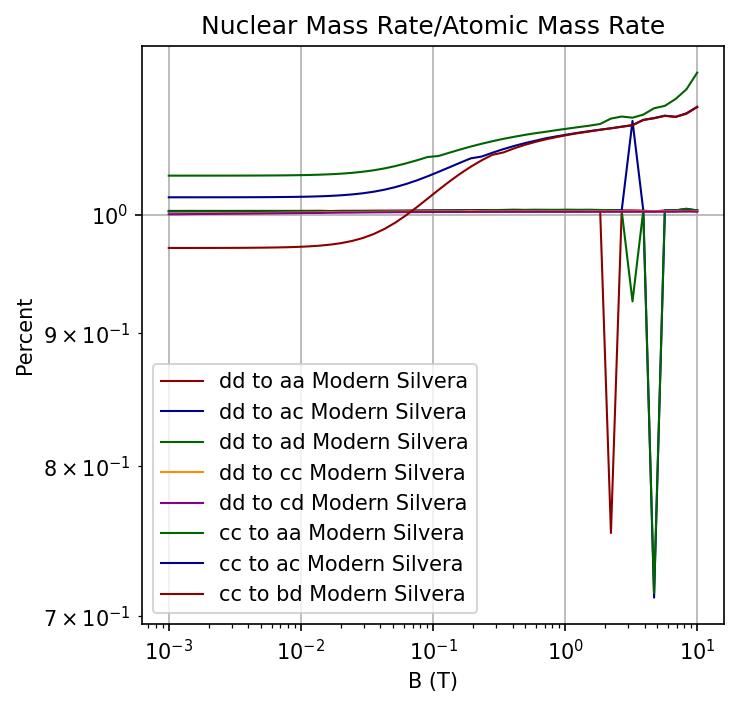

In [77]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpatials[0] / TDipSpatialsAtomic[0],label="dd to aa Modern Silvera", color = "DarkRed", linewidth=1)
plt.plot(B_Values,TDipSpatials[1] / TDipSpatialsAtomic[1],label="dd to ac Modern Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TDipSpatials[2] / TDipSpatialsAtomic[2],label="dd to ad Modern Silvera", color = "DarkGreen",linewidth=1)
plt.plot(B_Values,TDipSpatials[3] / TDipSpatialsAtomic[3],label="dd to cc Modern Silvera", color = "DarkOrange", linewidth=1)
plt.plot(B_Values,TDipSpatials[4] / TDipSpatialsAtomic[4],label="dd to cd Modern Silvera", color = "DarkMagenta", linewidth=1)
plt.plot(B_Values,TExSpatials[0] / TExSpatialsAtomic[0], label="cc to aa Modern Silvera", color = "DarkGreen", linewidth=1)
plt.plot(B_Values,TExSpatials[1] / TExSpatialsAtomic[1], label="cc to ac Modern Silvera", color = "DarkBlue", linewidth=1)
plt.plot(B_Values,TExSpatials[2] / TExSpatialsAtomic[2], label="cc to bd Modern Silvera", color = "DarkRed", linewidth=1)

plt.xlabel("B (T)")
plt.ylabel("Percent")
plt.title("Nuclear Mass Rate/Atomic Mass Rate")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

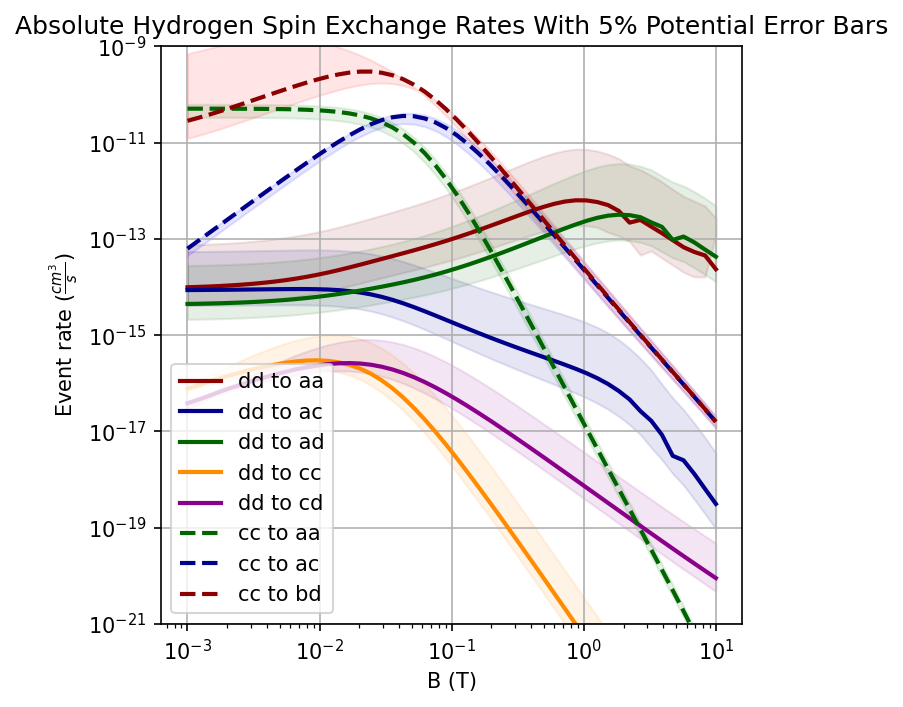

In [82]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0],label="dd to aa", color = "DarkRed", linewidth=2)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1],label="dd to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2],label="dd to ad", color = "DarkGreen",linewidth=2)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3],label="dd to cc", color = "DarkOrange", linewidth=2)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4],label="dd to cd", color = "DarkMagenta", linewidth=2)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0],  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1],  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2],  '--', label="cc to bd", color = "DarkRed", linewidth=2)

plt.fill_between(B_Values,np.asarray(downTSpatialsEx[0]*TExSpins[0],dtype=float) - uncertEx[0],np.asarray(upTSpatialsEx[0]*TExSpins[0],dtype=float) + uncertEx[0], color = "Green", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTSpatialsEx[1]*TExSpins[1],dtype=float) - uncertEx[1],np.asarray(upTSpatialsEx[1]*TExSpins[1],dtype=float) + uncertEx[1], color = "Blue", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTSpatialsEx[2]*TExSpins[2],dtype=float) - uncertEx[2],np.asarray(upTSpatialsEx[2]*TExSpins[2],dtype=float) + uncertEx[2], color = "Red", alpha=0.1)

plt.fill_between(B_Values,np.asarray(downTDipSpatials[0]*TDipSpins[0],dtype=float) - uncertDip[0],np.asarray(upTDipSpatials[0]*TDipSpins[0],dtype=float) + uncertDip[0], color = "DarkRed", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTDipSpatials[1]*TDipSpins[1],dtype=float) - uncertDip[1],np.asarray(upTDipSpatials[1]*TDipSpins[1],dtype=float) + uncertDip[1], color = "DarkBlue", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTDipSpatials[2]*TDipSpins[2],dtype=float) - uncertDip[2],np.asarray(upTDipSpatials[2]*TDipSpins[2],dtype=float) + uncertDip[2], color = "DarkGreen", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTDipSpatials[3]*TDipSpins[3],dtype=float) - uncertDip[3],np.asarray(upTDipSpatials[3]*TDipSpins[3],dtype=float) + uncertDip[3], color = "DarkOrange", alpha=0.1)
plt.fill_between(B_Values,np.asarray(downTDipSpatials[4]*TDipSpins[4],dtype=float) - uncertDip[4],np.asarray(upTDipSpatials[4]*TDipSpins[4],dtype=float) + uncertDip[4], color = "DarkMagenta", alpha=0.1)

plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-9)
plt.title("Absolute Hydrogen Spin Exchange Rates With 5% Potential Error Bars")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

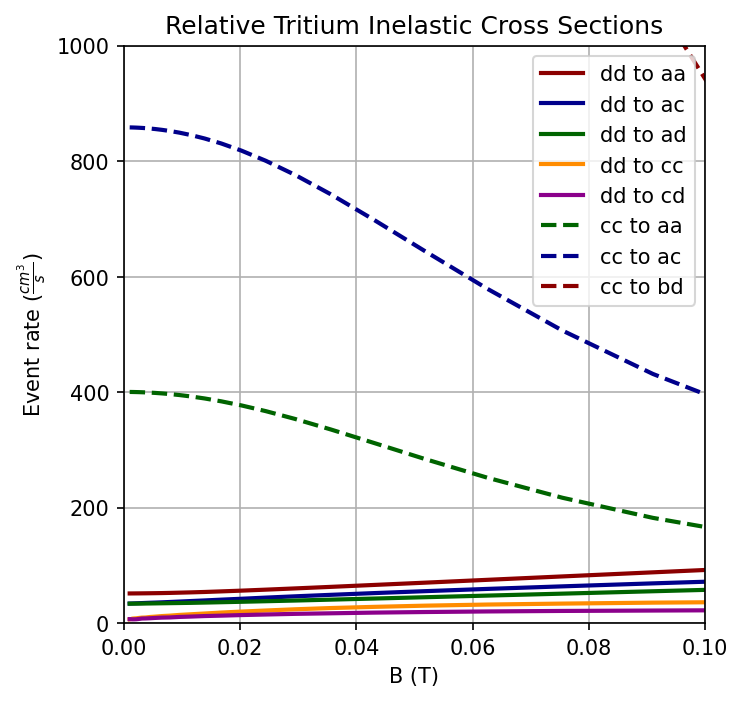

In [55]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TDipSpins[0] * TDipSpatials[0] / (HDipSpins[0] * HDipSpatials[0]),label="dd to aa", color = "DarkRed", linewidth=2)
plt.plot(B_Values,TDipSpins[1] * TDipSpatials[1] / (HDipSpins[1] * HDipSpatials[1]),label="dd to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TDipSpins[2] * TDipSpatials[2] / (HDipSpins[2] * HDipSpatials[2]),label="dd to ad", color = "DarkGreen",linewidth=2)
plt.plot(B_Values,TDipSpins[3] * TDipSpatials[3] / (HDipSpins[3] * HDipSpatials[3]),label="dd to cc", color = "DarkOrange", linewidth=2)
plt.plot(B_Values,TDipSpins[4] * TDipSpatials[4] / (HDipSpins[4] * HDipSpatials[4]),label="dd to cd", color = "DarkMagenta", linewidth=2)
plt.plot(B_Values,TExSpins[0] * TExSpatials[0] / (HExSpins[0] * HExSpatials[0]),  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,TExSpins[1] * TExSpatials[1] / (HExSpins[1] * HExSpatials[1]),  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TExSpins[2] * TExSpatials[2] / (HExSpins[2] * HExSpatials[2]),  '--', label="cc to bd", color = "DarkRed", linewidth=2)

plt.xlabel("B (T)")
plt.xlim(0,.1)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(0,1000)
plt.title("Relative Tritium Inelastic Cross Sections")
plt.grid(True)
plt.legend()
#plt.loglog()
plt.show()

In [56]:
def GetSpatialsDipTemp (mu, Temps, couple, levels, version):
    aaSpatials = []
    acSpatials = []
    adSpatials = []
    ccSpatials = []
    cdSpatials = []

    Conversion = ((1.973269804e-5)/(5.29177210544e-9))**2
    Pre_Factor  = 1/(5*np.pi) * couple**4
    
    i = 0
    for t in Temps:
        a = levels['a'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        intlimit = .75

        Pin = p_of_temp(mu, t)
        Paa_out = pprime(Pin, d, d, a, a, mu)
        Pac_out = pprime(Pin, d, d, a, c, mu)
        Pad_out = pprime(Pin, d, d, a, d, mu)
        Pcc_out = pprime(Pin, d, d, c, c, mu)
        Pcd_out = pprime(Pin, d, d, c, d, mu)

        aaIntegral = GetIntegral(d, d, a, a, mu, intlimit, r0, t, version, 'Radau')
        acIntegral = GetIntegral(d, d, a, c, mu, intlimit, r0, t, version, 'Radau')
        adIntegral = GetIntegral(d, d, a, d, mu, intlimit, r0, t, version, 'Radau')
        ccIntegral = GetIntegral(d, d, c, c, mu, intlimit, r0, t, version, 'Radau')
        cdIntegral = GetIntegral(d, d, c, d, mu, intlimit, r0, t, version, 'Radau')

        aaSpatials.append(Conversion * Pre_Factor * Paa_out * mu**2 * aaIntegral**2 / Pin)
        acSpatials.append(Conversion * Pre_Factor * Pac_out * mu**2 * acIntegral**2 / Pin)
        adSpatials.append(Conversion * Pre_Factor * Pad_out * mu**2 * adIntegral**2 / Pin)
        ccSpatials.append(Conversion * Pre_Factor * Pcc_out * mu**2 * ccIntegral**2 / Pin)
        cdSpatials.append(Conversion * Pre_Factor * Pcd_out * mu**2 * cdIntegral**2 / Pin)

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    adSpatials = np.array(adSpatials)
    ccSpatials = np.array(ccSpatials)
    cdSpatials = np.array(cdSpatials)

    return (aaSpatials, acSpatials, adSpatials, ccSpatials, cdSpatials)

In [57]:
def GetSpatialsExTemp(mu, temps, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    i = 0
    for t in temps:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        intlimit = 10 * BohrInAng/hcInEVAngstrom

        Pin = p_of_temp(mu, t)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const = np.pi / (Pin)
        conversion = ((1.973269804e-5)/(5.29177210544e-9))**2
        
        tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(conversion * const * (Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(conversion * const * (Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(conversion * const * (Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))


    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [58]:
Temp_Values = np.logspace(-3,2,50)

In [90]:
HDipSpatialsTemp = GetSpatialsDipTemp(Hmu, Temp_Values, mu_dip_couple, HLevels, Silvera_Triplet)
TDipSpatialsTemp = GetSpatialsDipTemp(Tmu, Temp_Values, mu_dip_couple, TLevels, Silvera_Triplet)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_32548/2640721410.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


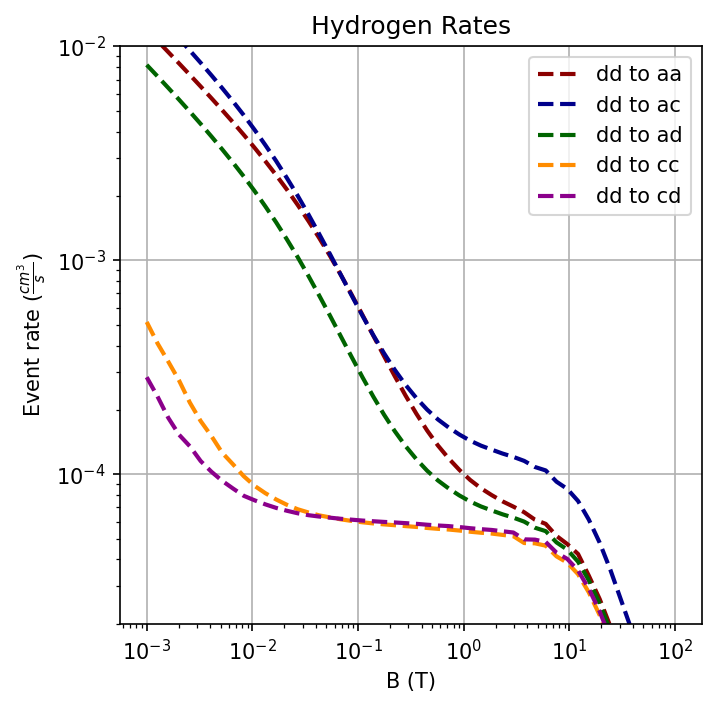

In [91]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(Temp_Values,HDipSpatialsTemp[0] * HDipSpins[0][0], '--', label="dd to aa", color = "DarkRed", linewidth=2)
plt.plot(Temp_Values,HDipSpatialsTemp[1] * HDipSpins[1][0], '--', label="dd to ac", color = "DarkBlue", linewidth=2)
plt.plot(Temp_Values,HDipSpatialsTemp[2] * HDipSpins[2][0], '--', label="dd to ad", color = "DarkGreen",linewidth=2)
plt.plot(Temp_Values,HDipSpatialsTemp[3] * HDipSpins[3][0], '--', label="dd to cc", color = "DarkOrange", linewidth=2)
plt.plot(Temp_Values,HDipSpatialsTemp[4] * HDipSpins[4][0], '--', label="dd to cd", color = "DarkMagenta", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(2e-5,.01)
plt.title("Hydrogen Rates")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [92]:
with open('./wpd_project-2.json') as f:
    data = json.load(f)

dataset1 = data['datasetColl'][0]['data']
x1 = [pt['value'][0] for pt in dataset1]
y1 = [pt['value'][1] for pt in dataset1]
y1_new = [y1 / np.sqrt(x1)]

dataset2 = data['datasetColl'][1]['data']
x2 = [pt['value'][0] for pt in dataset2]
y2 = [pt['value'][1] for pt in dataset2]
y2_new = [y2 / np.sqrt(x2)]

mp = 1.672621925e-27
me = 9.1093837139e-31
muH = me+mp/2
kb = 1.380649e-23
bohr = 5.29177210544e-9
A = 1e-2 / bohr**2 * np.sqrt(muH/(2*kb))*1e-15

In [93]:
y1_new = np.array(y1_new).flatten()
y2_new = np.array(y2_new).flatten()

(-4.522878745280337, -1.6989700043360187)

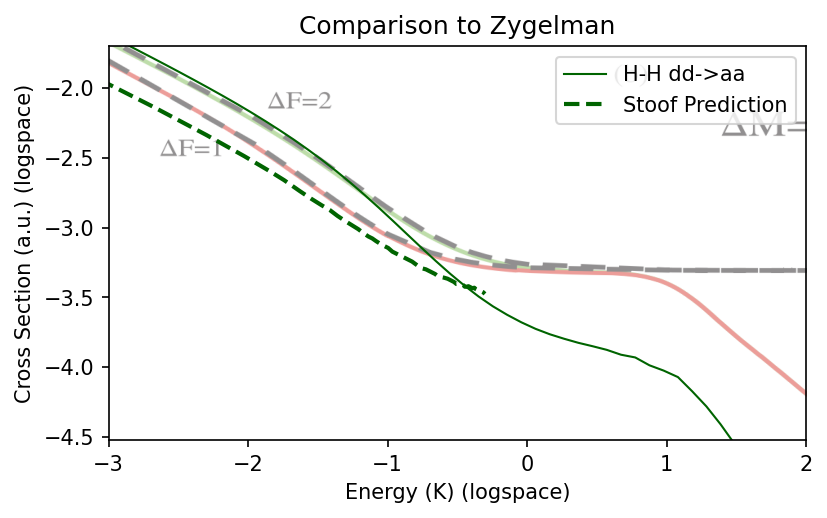

In [97]:
image = mpimg.imread("./ZYG1.b.png")

x_min, x_max = .001, 100
y_min, y_max = 3e-5, .02

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Stoof_array = np.array(x1, dtype=float)
Stoof_log = np.log10(Stoof_array)

Haa_array = np.array(HDipSpatialsTemp[0] * HDipSpins[0][0] * 2, dtype=float)
S_array = np.array(A * y1_new, dtype=float)

Haa_log = np.log10(Haa_array)
S_log = np.log10(S_array)

ax.plot(Temp_log, Haa_log, label = "H-H dd->aa", color="DarkGreen", linewidth=1)
ax.plot(Stoof_log, S_log, label="Stoof Prediction", linestyle = '--', color="DarkGreen", linewidth=2)

ax.set_xlabel("Energy (K) (logspace)")
ax.set_ylabel("Cross Section (a.u.) (logspace)")
ax.set_title("Comparison to Zygelman")
ax.legend(loc='upper right')

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

(-4.698970004336019, -2.0)

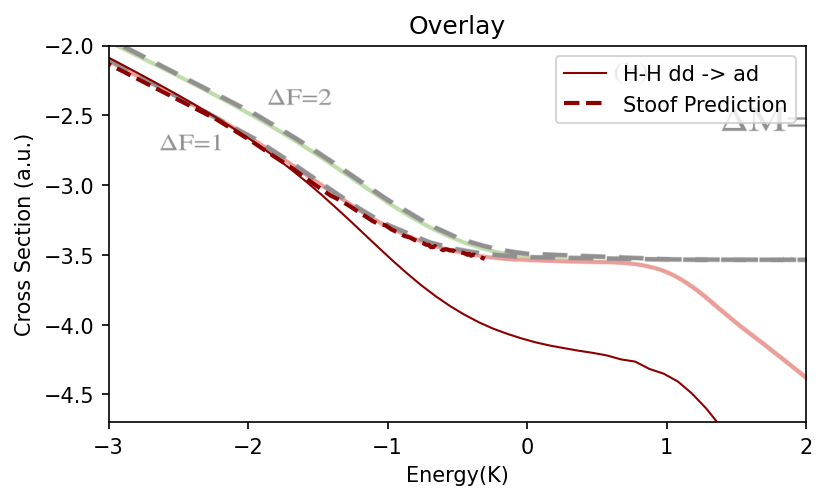

In [95]:
mage = mpimg.imread("./ZYG1.a.png")

x_min, x_max = .001, 100
y_min, y_max = 2e-5, .01

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Stoof_array = np.array(x2, dtype=float)
Stoof_log = np.log10(Stoof_array)

Had_array = np.array(HDipSpatialsTemp[2] * HDipSpins[2][0], dtype=float)
S_array = np.array(A * y2_new, dtype=float)

Had_log = np.log10(Had_array)
S_log = np.log10(S_array)

ax.plot(Temp_log, Had_log, label="H-H dd -> ad", color="DarkRed", linewidth=1)
ax.plot(Stoof_log, S_log, label="Stoof Prediction", linestyle = '--', color="DarkRed", linewidth=2)
ax.legend(loc='upper right')


ax.set_xlabel("Energy(K)")
ax.set_ylabel("Cross Section (a.u.)")
ax.set_title("Overlay")
ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

(-4.0, 0.0)

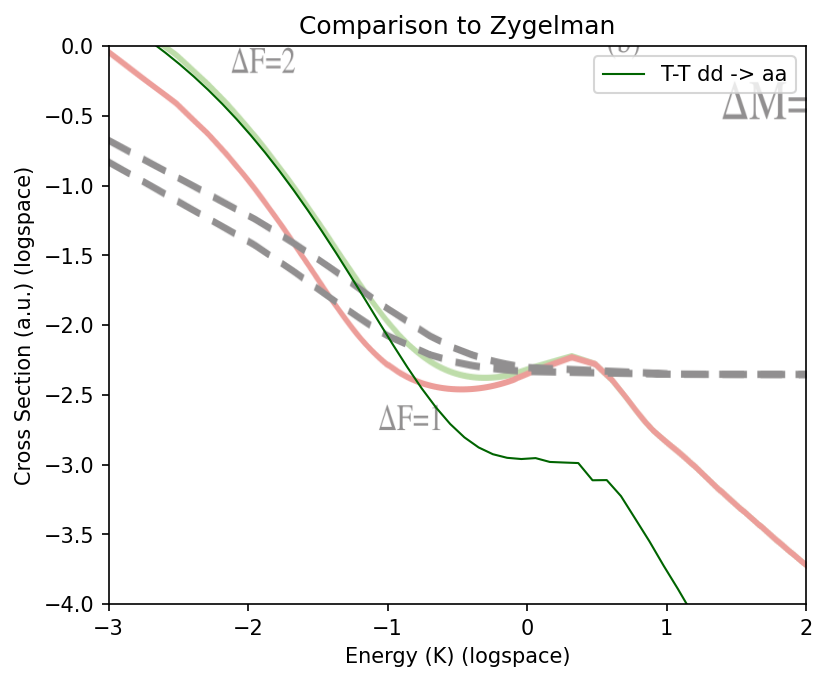

In [98]:
image = mpimg.imread("./ZYG3.b.png")

x_min, x_max = .001, 100
y_min, y_max = 1e-4, 1

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Taa_array = np.array(TDipSpatialsTemp[0] * TDipSpins[0][0] * np.sqrt(Tmu/Hmu), dtype=float)

Taa_log = np.log10(Taa_array)

ax.plot(Temp_log, Taa_log, label="T-T dd -> aa", color="DarkGreen", linewidth=1)

ax.set_xlabel("Energy (K) (logspace)")
ax.set_ylabel("Cross Section (a.u.) (logspace)")
ax.set_title("Comparison to Zygelman")
ax.legend(loc='upper right')

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

(-4.0, 0.0)

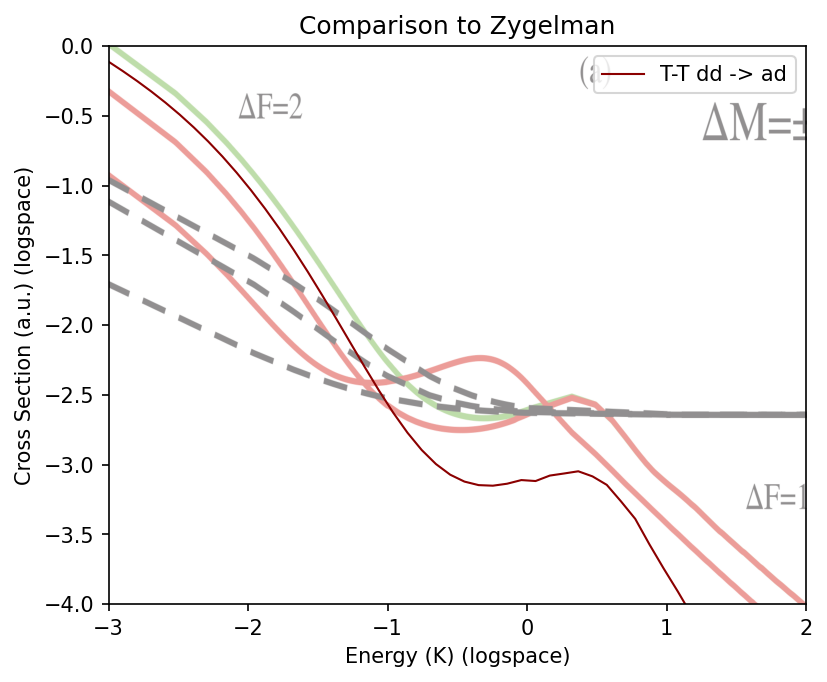

In [87]:
image = mpimg.imread("./ZYG3.a.png")

x_min, x_max = .001, 100
y_min, y_max = 1e-4, 1

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Tad_array = np.array(TDipSpatialsTemp[2] * TDipSpins[2][0] * np.sqrt(Tmu/Hmu), dtype=float)

Tad_log = np.log10(Tad_array)

ax.plot(Temp_log, Tad_log, label="T-T dd -> ad", color="DarkRed", linewidth=1)
ax.legend(loc='upper right')

ax.set_xlabel("Energy (K) (logspace)")
ax.set_ylabel("Cross Section (a.u.) (logspace)")
ax.set_title("Comparison to Zygelman")
ax.legend(loc='upper right')

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

In [88]:
with open('./wpd_project-3.json') as f:
    data = json.load(f)

dataset1 = data['datasetColl'][0]['data']
x = [pt['value'][0] for pt in dataset1]
y = [pt['value'][1] for pt in dataset1]
y_new = [y / np.sqrt(x)]
y_new = np.array(y_new).flatten()

mp = 1.672621925e-27
me = 9.1093837139e-31
muH = me+mp/2
kb = 1.380649e-23
bohr = 5.29177210544e-9
A = 1e-2 / bohr**2 * np.sqrt(muH/(2*kb))*1e-12

In [89]:
HExSpatialsTemp = GetSpatialsExTemp(Hmu, Temp_Values, HLevels, Silvera_Triplet, singletcombo)
TExSpatialsTemp = GetSpatialsExTemp(Tmu, Temp_Values, TLevels, Silvera_Triplet, singletcombo)

(-0.6989700043360187, 4.0)

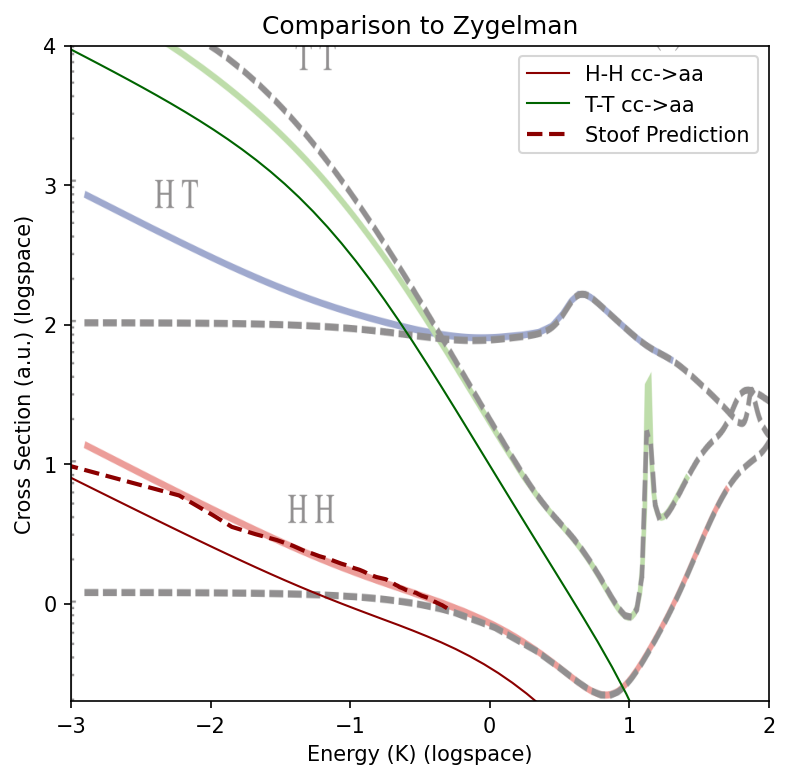

In [69]:
image = mpimg.imread("./ZYG4.a.png")


x_min, x_max = .001, 100
y_min, y_max = .2, 1e4

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)
Stoof_array = np.array(x2, dtype=float)
Stoof_log = np.log10(Stoof_array)

Haa_array = np.array(HExSpatialsTemp[0] * HExSpins[0][0], dtype=float)
Taa_array = np.array(TExSpatialsTemp[0] * TExSpins[0][0] * np.sqrt(Tmu/Hmu), dtype=float)
S_array = np.array(A * y_new, dtype=float)

Haa_log = np.log10(Haa_array)
Taa_log = np.log10(Taa_array)

S_log = np.log10(S_array)

ax.plot(Temp_log, Haa_log, label="H-H cc->aa", color="DarkRed", linewidth=1)
ax.plot(Temp_log, Taa_log, label="T-T cc->aa", color="DarkGreen", linewidth=1)
ax.plot(Stoof_log, S_log, label="Stoof Prediction", linestyle = '--', color="DarkRed", linewidth=2)
ax.legend(loc='upper right')


ax.set_xlabel("Energy (K) (logspace)")
ax.set_ylabel("Cross Section (a.u.) (logspace)")
ax.set_title("Comparison to Zygelman")
ax.legend(loc='upper right')

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)